In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ast, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_yaml
import matplotlib.colors as mcolors
plt.rcParams["figure.figsize"] = (10,10)
numero = 1
# Medio Ambiente
# Social Externo
# Social Interno
# Gobierno Corporativo
path_area = "gob"
area = 'Gobierno Corporativo'
def enumerate_dimensions(dimension, list_dimensions): 
    return list_dimensions.index(dimension)
def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

df = pd.read_csv('./Data/Flujo{num}.csv'.format(num=numero), sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary.append('')
vocabulary = list(sorted(set(vocabulary)))
vocab_len= len(vocabulary)+1
df = df[df.Area == area]
# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)

In [3]:
df_dim = pd.DataFrame(zip(range(14), list_dimensions), columns=['#','Dimension'])
#df_dim['Cantidad de datos'] = df_dim['Dimension'].apply(lambda x: df[['Dimension', 'Respuesta']].groupby('Dimension').count()['Respuesta'][x] )
df_dim.to_csv('./Herramientas/dims_{}.csv'.format(path_area), sep=';', index=False)

In [6]:
df = pd.read_csv('./Herramientas/dims_{}.csv'.format(path_area), sep=';' )
type(df.Dimension[1])

str

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


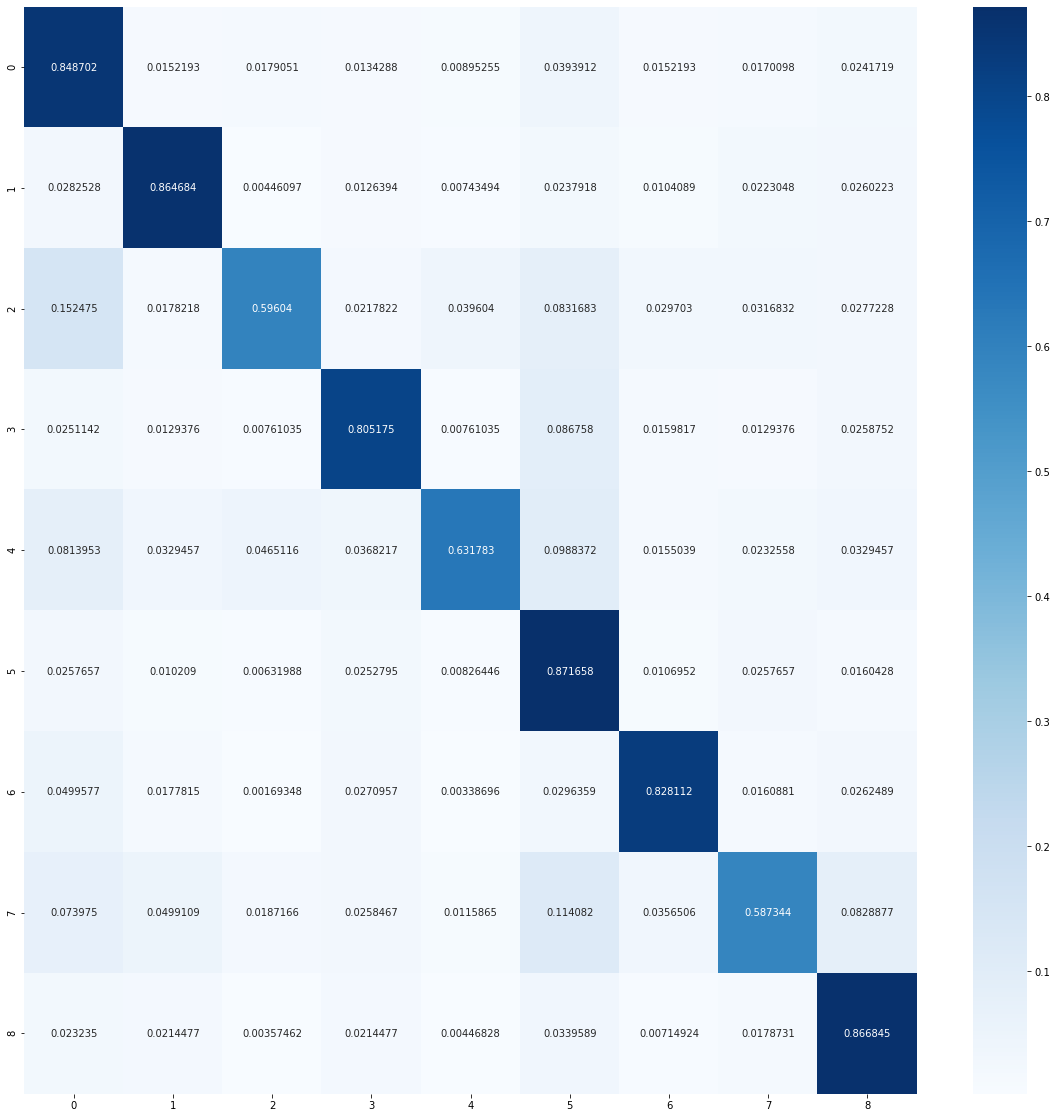

In [2]:
df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)
# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)
y_completo = np.array(df['_dimension'])
X_train, X_test, y_train, y_test = train_test_split(X_completo, y_completo, test_size=0.2, random_state=42)

path = './RNN/Salida/Flujo{num}/{area}/'.format(area = path_area.upper(),num = numero)

import seaborn as sn
model = tf.keras.models.load_model(path+'model_{}.h5'.format(path_area))
predictions = model.predict_classes(tf.convert_to_tensor(list(X_test)))
matrix = confusion_matrix(y_test, predictions, normalize='true')
plt.figure(figsize=(20,20))
sn.heatmap(matrix, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.savefig(path+"confm.png")

In [10]:
set(predictions)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12}

In [9]:
set(list_dimensions)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

<ipython-input-11-8167d8223b96>:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vec = np.add(feature_vec,model[word])
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


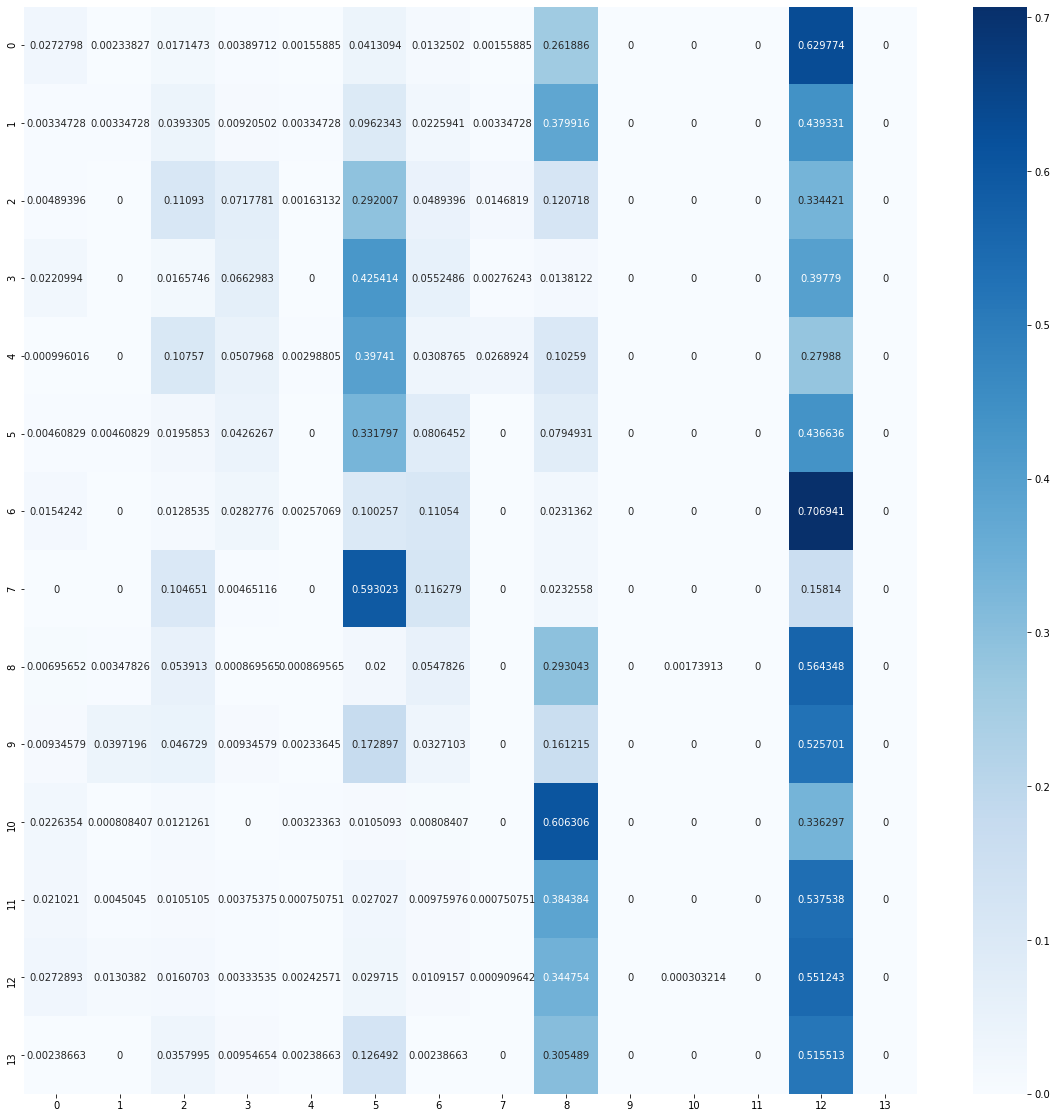

In [11]:
from gensim.models import Word2Vec,KeyedVectors
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
import ast, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_yaml
import matplotlib.colors as mcolors

plt.rcParams["figure.figsize"] = (10,10)
numero = 1
# Medio Ambiente
# Social Externo
# Social Interno
# Gobierno Corporativo
path_area = "soce"
area = 'Social Externo'
import joblib

def enumerate_dimensions(dimension, list_dimensions):
    return list_dimensions.index(dimension)

def make_feature_vec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model[word])
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

def get_avg_feature_vecs(reviews, model, num_features):
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

df = pd.read_csv('./Data/Flujo{num}.csv'.format(num=numero), sep=";")
df = df[df.Area == area]
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)
list_responses = np.array(df.Respuesta)
list_dimensions = np.array(df._dimension)
num_features = 10
model = Word2Vec.load('./modelWord2vec_flujo{num}.bin'.format(num=numero))
list_responses_vec = get_avg_feature_vecs(list_responses, model, num_features)

path = './Random_Forest/Salida/Flujo{num}/{area}/'.format(area = path_area.upper(),num = numero)
forest = joblib.load(path+'model.pkl')

X_train, X_test, y_train, y_test = train_test_split(list_responses_vec,
                                                    list_dimensions,
                                                    test_size=0.2)

import seaborn as sn
predictions = forest.predict(X_test)
matrix = confusion_matrix(y_test, predictions, normalize='true')
plt.figure(figsize=(20,20))
sn.heatmap(matrix, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.show()
#plt.savefig(path+"confm.png")